In [1]:
import sys
sys.path.append('../') ##accrocchio
from src.utils import retrive_data,split
import pickle

In [3]:
labeled,labeled_small,to_remove = retrive_data(False,threshold_under_represented=0.5,path='/home/agobbi/Projects/PID/datanalytics/PID/src')

In [4]:
dataset,dataset_test = split(labeled_small,
                                SKI_AREA_TEST= 'Klausberg',
                                SEASON_TEST_SKIAREA = 'Kronplatz',
                                SEASON_TEST_YEAR= 2023,
                                use_smote = False,
                                weight_type = 'sqrt' )

   class          p
0      0   0.203424
1      1   0.013596
2      2   0.056109
3      3   1.130661
4      4  16.206137


In [5]:
with open('../src/best_params_and_final_model.pkl','rb') as f:
    tot,bst_FS,FS = pickle.load(f)  

In [36]:
import shap
import xgboost as xgb
import numpy as np
dtest_FS = xgb.DMatrix(dataset_test.X_test_area[bst_FS.feature_names],dataset_test.y_test_area,enable_categorical=True,)

explainer = shap.TreeExplainer(bst_FS,feature_names=bst_FS.feature_names)
shap_values = explainer.shap_values(dtest_FS)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [37]:
shap.initjs()

In [38]:
pred = bst_FS.predict(dtest_FS)


array([2.58451770e-03, 2.63414029e-02, 8.63697469e-01, 1.07182816e-01,
       1.93854154e-04], dtype=float32)

In [39]:
dataset_test.X_test_area[bst_FS.feature_names].iloc[2]

age                                           53.0
diagnosis                              dislocation
injury_general_location                upper_limbs
country                                   Germania
difficulty                                    easy
cause                                   fall_alone
destination                hospital_emergency_room
injury_side                                      R
equipment                                      ski
gender                                           F
snowmobile                                    True
helicopter                                    True
akja                                         False
helmet                                        True
ambulance                                    False
snowmobile_sled                              False
ski_lift                                     False
indipendently                                False
skiarea_ambulance                            False
other                          

In [51]:
dataset_test.y_test_area.iloc[2]

2

In [44]:
np.round(pred[2]*100)

array([ 0.,  3., 86., 11.,  0.], dtype=float32)

In [64]:
[shap_values[i][2].sum() for i in range(5)]

[-3.5973988, -1.704391, 1.8931085, -0.9031036, -7.5351233]

In [71]:
i=1
shap.plots.force(explainer.expected_value[1], shap_values[i][2],feature_names=bst_FS.feature_names)


In [70]:
i=2
shap.plots.force(explainer.expected_value[1], shap_values[i][2],feature_names=bst_FS.feature_names)

In [6]:
import psycopg2 as pg
import pandas as pd
engine = pg.connect("dbname='safeidx' user='fbk_mpba' host='172.104.247.67' port='5432' password='fbk2024$'")
df = pd.read_sql('select * from fbk_export_20240212', con=engine) 

/tmp/ipykernel_48291/444630369.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('select * from fbk_export_20240212', con=engine)


In [7]:
df = df[pd.isna(df.india)] ##solo quelli senza label

In [8]:
from src.utils import prepare_new_data
with open('../src/to_remove.pkl','rb') as f:
    to_remove = pickle.load(f)


In [9]:
dataset_p,dataset_p_small = prepare_new_data(df,to_remove)

/home/agobbi/Projects/PID/datanalytics/PID/notebooks/../src/utils.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset_p_small.loc[dataset_p[c]==k,c] = 'other'
/home/agobbi/Projects/PID/datanalytics/PID/notebooks/../src/utils.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_p_small[c] =  dataset_p_small[c].fillna('None').astype('category')


In [15]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
unlabeled_dm = xgb.DMatrix(dataset_p_small[bst_FS.feature_names],enable_categorical=True,)


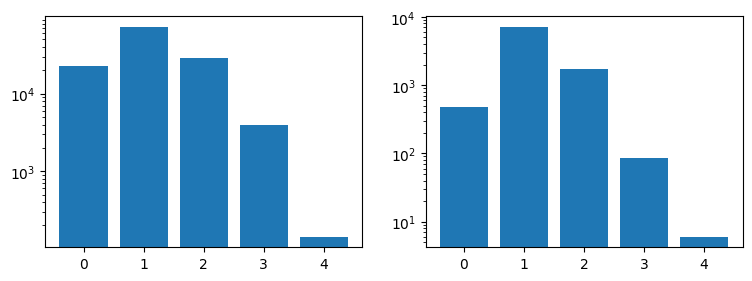

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].bar(range(5),np.unique(np.argmax(bst_FS.predict(unlabeled_dm),1),return_counts=True)[1])
axs[0].set_yscale("log", base=10)
axs[1].bar(range(5),np.unique(dataset.y_train,return_counts=True)[1])
axs[1].set_yscale("log", base=10)

In [45]:
with open('../src/best_params.pkl','rb') as f:
    params_final,feat_imp,best_model = pickle.load(f)

In [53]:
xgb.Booster

xgboost.core.Booster

<Axes: >

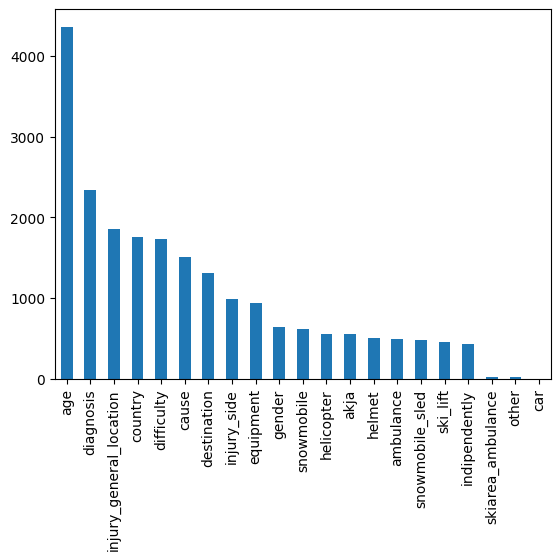

In [48]:
feat_imp.plot(kind='bar')

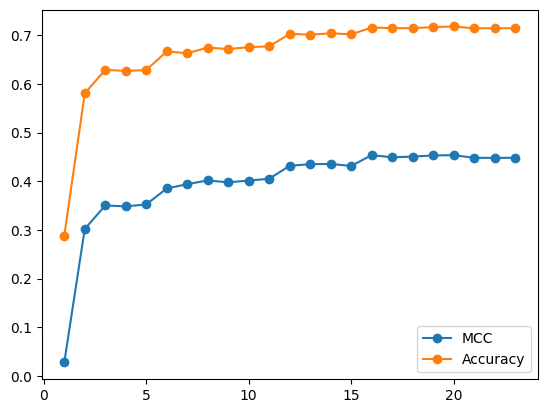

In [51]:
plt.plot(tot.FS,tot.mcc,'o-', label='MCC')
plt.plot(tot.FS,tot.acc,'o-', label='Accuracy')
plt.legend()